In [220]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [221]:
import omegaconf
from shell.utils.experiment_utils import *
from shell.fleet.utils.fleet_utils import *
from shell.utils.metric import *
import matplotlib.pyplot as plt
from shell.fleet.network import TopologyGenerator
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
from shell.fleet.fleet import Agent, Fleet
from shell.fleet.data.data_utilize import *
from shell.fleet.data.recv import *

from sklearn.manifold import TSNE
from torchvision.utils import make_grid
from shell.fleet.data.data_utilize import *
import logging
from sklearn.metrics import f1_score
import os
from shell.fleet.data.recv_utils import *
from pythresh.thresholds.aucp import AUCP
from pythresh.thresholds.boot import BOOT
from pythresh.thresholds.zscore import ZSCORE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import defaultdict
from plot import *
import seaborn as sns
import re

plt.style.use('seaborn-whitegrid')
logging.basicConfig(level=logging.CRITICAL)

/tmp/ipykernel_1671563/1111328684.py:30: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [222]:
def format_df_for_table(data_seed_aucs):
    # data_seed_aucs is a dict of structure data_seed_aucs[dataset][seed][algo] = auc
    # we need to format it into a df with columns: algo, dataset, value where value is the mean auc over seeds
    data = []
    for dataset, seed_aucs in data_seed_aucs.items():
        for seed, aucs in seed_aucs.items():
            for algo, auc in aucs.items():
                data.append({'dataset': dataset, 'seed': seed, 'algo': algo, 'auc': auc})
    df = pd.DataFrame(data)
    df = df.groupby(['dataset', 'algo']).agg({'auc': ['mean', 'std', 'sem']}).reset_index()
    df.columns = ['dataset', 'algo', 'mean', 'std', 'sem']
    return df

In [223]:
# choices = ["all_avg", "modular_ablation", "modular", "monolithic", "modmod_budget", "fedavg_monolithic_budget" "fedavg_modular_budget" "recv_modular" "recv_monolithic"
# "modmod_topology" "fedavg_modular_topology" "fedavg_monolithic_topology"]
# what_to_plot = "all_avg"
what_to_plot = "modular"
what_to_plot = "combine_modes_modular"
# what_to_plot = "combine_modes_monolithic"
# what_to_plot = "modular_ablation"
# what_to_plot = "monolithic"
# what_to_plot = "recv_modular"
# what_to_plot = "recv_monolithic"
# what_to_plot = "fedavg_monolithic_budget"



# what_to_plot = "fedavg_modular_topology"
# what_to_plot = "fedavg_monolithic_topology"
# what_to_plot = "modmod_topology"


# what_to_plot = "monolithic_fl_zoo"
# what_to_plot = "modular_fl_zoo"

# what_to_plot = "fedavg_modular_budget"

In [224]:
datasets = ["mnist", "kmnist", "fashionmnist", "combined", "cifar100"]
# datasets = ["combined"]
# datasets = ["mnist", "kmnist", "fashionmnist", "combined"]
# datasets = ["kmnist"]
# datasets = ["mnist"]
# datasets = ["mnist", "kmnist"]
# datasets = ["mnist", "combined"]
# datasets = ["mnist", "cifar100"]
# datasets = ["combined"]
# datasets=["cifar100"]
# datasets=["mnist", "fashionmnist"]
experiment_folder = "experiment_results"


use_contrastive = True

viz = False
seeds = [0, 1, 2, 3, 4, 5, 6, 7]
# seeds = [0, 1, 2, 3, 4]
# seeds = [0]
# seeds = [4]
tasks=None
agent_ids = None
ax=None
sync_bases = [True]
opt_with_randoms = [False]

metric='test_acc'



# agent_ids = ['agent_5']
# tasks=range(4,10)
# tasks=[5]
# seeds = [0]


num_tryout_epochs = 20
max_num_modules_tryout = 3
num_shared_module_list = [1,2,3,4]

fedavg_comm_freq = [5, 10, 20, 50, 100]

recv_num_queries = [10, 20, 30]
recv_comm_freq = [9, 16, 50]


# for combine_modes
add_data_backward = True
make_new_opt = False
no_sparse = True


def modify_cfg(net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg):
    if "sync_base" not in cfg.sharing_strategy:
        cfg.sharing_strategy['sync_base'] = False
    return net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg

if what_to_plot == "all_avg":
    algos = ['monolithic', 'modular']
    mode = "avg"
elif "modular" in what_to_plot or "modmod" in what_to_plot:
    algos = ['modular']
    mode = "current"
elif "monolithic" in what_to_plot:
    algos = ['monolithic']
    mode = "avg"
else:
    raise ValueError("Invalid choice")

## TMP
mode='avg'

use_contrastive_list = [False]

freeze_candidate_module = False
no_sparse_basis_ls = [True]

if what_to_plot == "modular_ablation":
    transfer_decoder_ls = [True, False]
    transfer_structure_ls = [True, False]
else:
    transfer_decoder_ls = [True]
    transfer_structure_ls = [True]



# if "combine_modes" in what_to_plot:
#     mode = "avg"

In [225]:
def get_save_dirs_modmod(dataset, seed):
    save_dirs = {}
    num_trains_per_class = 64 if dataset != "cifar100" else 256
    for sync_base in sync_bases:
        for opt_with_random in opt_with_randoms:
            for use_contrastive_opt in use_contrastive_list:
                for transfer_decoder in transfer_decoder_ls:
                    for transfer_structure in transfer_structure_ls:
                        for no_sparse_basis in no_sparse_basis_ls:
                            if dataset == "combined":
                                experiment_name = f"leep_jorge_setting_lowest_task_id_wins_modmod_test_sync_base_{sync_base}_opt_with_random_{opt_with_random}_frozen_{freeze_candidate_module}_transfer_decoder_{transfer_decoder}_transfer_structure_{transfer_structure}_no_sparse_basis_{no_sparse_basis}"
                            else:
                               experiment_name = f"jorge_setting_lowest_task_id_wins_modmod_test_sync_base_{sync_base}_opt_with_random_{opt_with_random}_frozen_{freeze_candidate_module}_transfer_decoder_{transfer_decoder}_transfer_structure_{transfer_structure}_no_sparse_basis_{no_sparse_basis}"
                            # experiment_name = f"leep_jorge_setting_lowest_task_id_wins_modmod_test_sync_base_{sync_base}_opt_with_random_{opt_with_random}_frozen_{freeze_candidate_module}_transfer_decoder_{transfer_decoder}_transfer_structure_{transfer_structure}_no_sparse_basis_{no_sparse_basis}"




                            if use_contrastive_opt:
                                name += "_contrastive"
                            name = f'jorge_setting_lowest_id_sync_{sync_base}_rand_{opt_with_random}_transfer_decoder_{transfer_decoder}_transfer_structure_{transfer_structure}_no_sparse_basis_{no_sparse_basis}'
                            save_dirs[name] = get_save_dir(experiment_folder, experiment_name,
                                                    dataset, "modular", num_trains_per_class, use_contrastive_opt, seed)
                            

                            # HACK
                            # save_dirs[name] = get_save_dir('.', "combine_modes_results/debug_modmod",
                            #                     dataset, 'modular', num_trains_per_class, use_contrastive_opt, seed)
                            # save_dirs[name] = get_save_dir('.', "combine_modes_results/debug_modmod_on_branch_combine_modes",
                            #                     dataset, 'modular', num_trains_per_class, use_contrastive_opt, seed)

    return save_dirs



def get_save_dirs_modmod_budget(dataset, seed, budget_experiment_folder=None):
    if budget_experiment_folder is None:
        budget_experiment_folder = experiment_folder

    save_dirs = {}
    num_trains_per_class = 64 if dataset != "cifar100" else 256
    for num_shared_module in num_shared_module_list:
        for sync_base in sync_bases:
            for opt_with_random in opt_with_randoms:
                for use_contrastive_opt in use_contrastive_list:
                    for transfer_decoder in transfer_decoder_ls:
                        for transfer_structure in transfer_structure_ls:
                            for no_sparse_basis in no_sparse_basis_ls:
                                if dataset == "combined":
                                    experiment_name = f"leep_tryout_epochs_{num_tryout_epochs}_max_modules_{max_num_modules_tryout}_num_shared_modules_{num_shared_module}_jorge_setting_lowest_task_id_wins_modmod_test_sync_base_{sync_base}_opt_with_random_{opt_with_random}_frozen_{freeze_candidate_module}_transfer_decoder_{transfer_decoder}_transfer_structure_{transfer_structure}_no_sparse_basis_{no_sparse_basis}"
                                else:
                                    experiment_name = f"tryout_epochs_{num_tryout_epochs}_max_modules_{max_num_modules_tryout}_num_shared_modules_{num_shared_module}_jorge_setting_lowest_task_id_wins_modmod_test_sync_base_{sync_base}_opt_with_random_{opt_with_random}_frozen_{freeze_candidate_module}_transfer_decoder_{transfer_decoder}_transfer_structure_{transfer_structure}_no_sparse_basis_{no_sparse_basis}"
                                name = f"tryout_epochs_{num_tryout_epochs}_max_modules_{max_num_modules_tryout}_num_shared_modules_{num_shared_module}_jorge_setting_lowest_task_id_wins_modmod_test_sync_base_{sync_base}_opt_with_random_{opt_with_random}_frozen_{freeze_candidate_module}_transfer_decoder_{transfer_decoder}_transfer_structure_{transfer_structure}_no_sparse_basis_{no_sparse_basis}"
                                if use_contrastive_opt:
                                    name += "_contrastive"
                                save_dirs[name] = get_save_dir(budget_experiment_folder, experiment_name,
                                                        dataset, "modular", num_trains_per_class, use_contrastive_opt, seed)

    return save_dirs


def get_save_dirs_recv(dataset, seed):
    save_dirs = {}
    num_trains_per_class = 64 if dataset != "cifar100" else 256
    experiment_name = f"jorge_setting_recv"
    for algo in algos:
        for use_contrastive_opt in use_contrastive_list:
            name = f"recv_{algo}"
            save_dirs[name] = get_save_dir(experiment_folder, experiment_name,
                                                dataset, algo, num_trains_per_class, use_contrastive_opt, seed)
            
            # save_dirs[name] = get_save_dir('.', "combine_modes_results/debug_recv_data",
            #                                     dataset, algo, num_trains_per_class, use_contrastive_opt, seed)
    return save_dirs
    

def get_save_dirs_combine_modes(dataset, seed):
    save_dirs = {}
    num_trains_per_class = 64 if dataset != "cifar100" else 256
    experiment_name = f"combine_modes_results/gt_recv_data_no_sparse_False_recv_mod_add_data_backward_True_make_new_opt_True"
    experiment_name = f"combine_modes_results/recv_data_no_sparse_False_recv_mod_add_data_backward_True_make_new_opt_True"
    experiment_name = f"combine_modes_results/modmod_no_sparse_True_recv_mod_add_data_backward_True_make_new_opt_True"
    experiment_name = f"combine_modes_results/modmod_no_sparse_True_recv_mod_add_data_backward_True_make_new_opt_False"
    experiment_name = f"debug_combine_modes_results/debug_modmod"
    # experiment_name = f"debug_combine_modes_results/jorge_setting_lowest_task_id_wins_modmod_test_sync_base_True_opt_with_random_False_frozen_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True"
    experiment_name = f"debug_combine_modes_results/gt_recv_data_no_sparse_False_recv_mod_add_data_backward_True_make_new_opt_True"
    experiment_name = f"debug_combine_modes_results/heuristic_data"
    # experiment_name = f"debug_combine_modes_results/recv_data_no_sparse_False_recv_mod_add_data_backward_True_make_new_opt_True"
    # experiment_name = f"debug_combine_modes_results/gt_fedavg_no_sparse_False_recv_mod_add_data_backward_True_make_new_opt_True"
    # experiment_name = f"/fedavg_data_no_sparse_False_recv_mod_add_data_backward_True_make_new_opt_True"
    # experiment_name = f"debug_combine_modes_results/debug_modmod"
    experiment_name = f"rerun_modmod_no_adaptation_results"
    for algo in algos:
        for use_contrastive_opt in use_contrastive_list:
            name = f"combine_{algo}"
            save_dirs[name] = get_save_dir('.', experiment_name,
                                                dataset, algo, num_trains_per_class, use_contrastive_opt, seed)
    return save_dirs
def get_save_dirs_base(dataset, seed):
    save_dirs = {}
    num_trains_per_class = 64 if dataset != "cifar100" else 256
    for algo in algos:
        for use_contrastive_opt in use_contrastive_list:
            for no_sparse_basis in no_sparse_basis_ls:
                if no_sparse_basis:
                    base_experiment_name = "vanilla_jorge_setting_basis_no_sparse"
                else:
                    base_experiment_name = "vanilla_jorge_setting"
                name = f'{algo}_no_sparse_basis_{no_sparse_basis}'
                if use_contrastive_opt:
                    name += "_contrastive"
                save_dirs[name] = get_save_dir(experiment_folder, base_experiment_name,
                                        dataset, algo, num_trains_per_class, use_contrastive_opt, seed)
    return save_dirs

def get_save_dirs_fedavg(dataset, seed):
    save_dirs = {}
    num_trains_per_class = 64 if dataset != "cifar100" else 256
    for algo in algos:
        for use_contrastive_opt in use_contrastive_list:
            name = f'fedavg_{algo}'
            save_dirs[name] = get_save_dir(experiment_folder, "jorge_setting_fedavg",
                                                dataset, algo, num_trains_per_class, use_contrastive_opt, seed)
            # save_dirs[name] = get_save_dir('.', "rerun_fedavg_results",
            #                                     dataset, algo, num_trains_per_class, use_contrastive_opt, seed)
    return save_dirs




def get_save_dirs_multiple_folders(dataset, seed, root_experiment_folder=None, patterns=None):
    if patterns is None:
        patterns = [r".*"]
    if root_experiment_folder is None:
        root_experiment_folder = experiment_folder
    save_dirs = {}
    num_trains_per_class = 64 if dataset != "cifar100" else 256
    for algo in algos:
        for use_contrastive_opt in use_contrastive_list:
            for folder in os.listdir(root_experiment_folder):
                if not os.path.isdir(os.path.join(root_experiment_folder, folder)) or not any([re.search(pattern, folder) for pattern in patterns]):
                    continue
                save_dirs[folder] = get_save_dir(root_experiment_folder, folder,
                                    dataset, algo, num_trains_per_class, use_contrastive_opt, seed)
    return save_dirs


def get_save_dirs(dataset, seed):
    save_dirs = {}

    if what_to_plot == "all_avg" or what_to_plot == "modular" or what_to_plot == "monolithic":
        save_dirs.update(get_save_dirs_base(dataset, seed))
        if "modular" in algos:
            save_dirs.update(get_save_dirs_modmod(dataset, seed))
        save_dirs.update(get_save_dirs_fedavg(dataset, seed))
        save_dirs.update(get_save_dirs_recv(dataset, seed))

        save_dirs.update(get_save_dirs_multiple_folders(dataset, seed, 
        root_experiment_folder="best_fl_results",
        ))

        # save_dirs.update(get_save_dirs_multiple_folders(dataset, seed,
        #     root_experiment_folder="combine_modes_all_results",))

        # save_dirs.update(get_save_dirs_combine_modes(dataset, seed))

    elif "combine_modes" in what_to_plot:
        save_dirs.update(get_save_dirs_base(dataset, seed))

        # save_dirs.update(get_save_dirs_multiple_folders(dataset, seed,
        # root_experiment_folder="monolithic_combine_modes_results",))

        # save_dirs.update(get_save_dirs_multiple_folders(dataset, seed,
        # root_experiment_folder="cifar100_monolithic_combine_modes_results",))

        # if "modular" in what_to_plot:
        #     save_dirs.update(get_save_dirs_multiple_folders(dataset, seed,
        #     root_experiment_folder="combine_modes_results",))

        # save_dirs.update(get_save_dirs_multiple_folders(dataset, seed,
        # root_experiment_folder="debug_combine_modes_results",))

        # save_dirs.update(get_save_dirs_multiple_folders(dataset, seed,
        # root_experiment_folder="cifar_combine_modes_results",))

        if "modular" in algos:
            save_dirs.update(get_save_dirs_multiple_folders(dataset, seed,
            root_experiment_folder="combine_modes_all_results",))
        else:
            save_dirs.update(get_save_dirs_multiple_folders(dataset, seed,
            root_experiment_folder="monolithic_combine_modes_results",))

        if "modular" in algos:
            save_dirs.update(get_save_dirs_modmod(dataset, seed))
        save_dirs.update(get_save_dirs_fedavg(dataset, seed))
        save_dirs.update(get_save_dirs_recv(dataset, seed))


    elif what_to_plot == "modular_ablation":
        save_dirs.update(get_save_dirs_base(dataset, seed))
        save_dirs.update(get_save_dirs_modmod(dataset, seed))
    elif what_to_plot == "modmod_budget":
        save_dirs.update(get_save_dirs_base(dataset, seed))
        save_dirs.update(get_save_dirs_modmod_budget(dataset, seed, budget_experiment_folder="budget_experiment_results/modmod"))
    elif "fedavg" in what_to_plot and "topology" in what_to_plot:
        save_dirs.update(get_save_dirs_base(dataset, seed))
        save_dirs.update(get_save_dirs_fedavg(dataset, seed))
        # save_dirs.update(get_save_dirs_multiple_folders(dataset, seed, root_experiment_folder="jorge_setting_fedavg/comm_freq_5",
        # save_dirs.update(get_save_dirs_multiple_folders(dataset, seed, root_experiment_folder="topology_experiment_results/topology_experiment_results/jorge_setting_fedavg/comm_freq_5",
        # mnist, fashionmnist, kmnist for fedavg monolithic
        # save_dirs.update(get_save_dirs_multiple_folders(dataset, seed, root_experiment_folder="rerun_topology_experiment_results/jorge_setting_fedavg/comm_freq_5",
        save_dirs.update(get_save_dirs_multiple_folders(dataset, seed, root_experiment_folder="new_topology_experiment_results/jorge_setting_fedavg/comm_freq_5",
        patterns=[r"disconnect", r"ring", r"server", r"tree"]))

    elif "fedavg" in what_to_plot:
        save_dirs.update(get_save_dirs_base(dataset, seed))
        save_dirs.update(get_save_dirs_multiple_folders(dataset, seed, root_experiment_folder="budget_experiment_results/jorge_setting_fedavg"))
    elif "recv" in what_to_plot:
        save_dirs.update(get_save_dirs_base(dataset, seed))
        # save_dirs.update(get_save_dirs_multiple_folders(dataset, seed, root_experiment_folder="budget_experiment_results/jorge_setting_recv_variable_shared_memory_size"))
        save_dirs.update(get_save_dirs_multiple_folders(dataset, seed, root_experiment_folder="modular_backward_cifar_heuristic_results_small_mem_32/budget"))
        # save_dirs.update(get_save_dirs_multiple_folders(dataset, seed, root_experiment_folder="cifar_heuristic_results_small_mem_32_results/budget"))
        # save_dirs.update(get_save_dirs_multiple_folders(dataset, seed, root_experiment_folder="combined_recv_results/combined_recv_results"))
        # save_dirs.update(get_save_dirs_multiple_folders(dataset, seed, root_experiment_folder="combined_recv_remove_neighbors_results"))

        if dataset == "cifar100":
            # remove all keys that has "mem_size" in it from save_dirs
            save_dirs = {k: v for k, v in save_dirs.items() if "mem_size" not in k}
        else:
            # remove all keys that has "heuristic"
            save_dirs = {k: v for k, v in save_dirs.items() if "heuristic" not in k}
    elif what_to_plot == "modmod_topology":
        save_dirs.update(get_save_dirs_base(dataset, seed))
        save_dirs.update(get_save_dirs_modmod(dataset, seed))
        save_dirs.update(get_save_dirs_multiple_folders(dataset, seed, root_experiment_folder="new_topology_experiment_results/modmod",
        patterns=[r"disconnect", r"ring", r"server", r"tree"]))
    elif 'fl_zoo' in what_to_plot:
        save_dirs.update(get_save_dirs_base(dataset, seed))
        save_dirs.update(get_save_dirs_fedavg(dataset, seed))
        save_dirs.update(get_save_dirs_multiple_folders(dataset, seed, 
        root_experiment_folder="best_fl_results",
        ))
        # patterns=[r"fedcurv"]))
        # patterns=[r"fedprox"]))
    else:
        raise ValueError("Invalid choice")
    return save_dirs

In [226]:
get_save_dirs("cifar100", 0)

{'modular_no_sparse_basis_True': 'experiment_results/vanilla_jorge_setting_basis_no_sparse/cifar100_modular_numtrain_256/cifar100/modular/seed_0',
 'modmod_no_sparse_True_recv_mod_add_data_backward_True_make_new_opt_False': 'combine_modes_all_results/modmod_no_sparse_True_recv_mod_add_data_backward_True_make_new_opt_False/cifar100_modular_numtrain_256/cifar100/modular/seed_0',
 'recv_data+grad_sharing_no_sparse_True_recv_mod_add_data_backward_True_make_new_opt_False': 'combine_modes_all_results/recv_data+grad_sharing_no_sparse_True_recv_mod_add_data_backward_True_make_new_opt_False/cifar100_modular_numtrain_256/cifar100/modular/seed_0',
 'grad_sharing_no_sparse_True_recv_mod_add_data_backward_True_make_new_opt_False': 'combine_modes_all_results/grad_sharing_no_sparse_True_recv_mod_add_data_backward_True_make_new_opt_False/cifar100_modular_numtrain_256/cifar100/modular/seed_0',
 'recv_data+modmod+grad_sharing_no_sparse_True_recv_mod_add_data_backward_True_make_new_opt_False': 'combine_m

In [227]:
dataset_seed_aucs, dataset_agg_dfs = load_data(get_save_dirs, seeds, datasets, modify_cfg, viz, tasks, agent_ids, ax, mode=mode,
                                               metric=metric, 
                                              #  strict=True)
                                               strict=False)

In [228]:
remap_name = {
    
    
             "modular_no_sparse_basis_True" : "modular (baseline)",
              "monolithic_no_sparse_basis_True": "monolithic (baseline)",
             "jorge_setting_lowest_id_sync_True_rand_False_transfer_decoder_False_transfer_structure_False_no_sparse_basis_True": "transfer modules",
             "jorge_setting_lowest_id_sync_True_rand_False_transfer_decoder_False_transfer_structure_True_no_sparse_basis_True": "transfer modules + structure",
             "jorge_setting_lowest_id_sync_True_rand_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True": "modmod",

            #  "jorge_setting_lowest_id_sync_False_rand_False_transfer_decoder_False_transfer_structure_False_no_sparse_basis_True": "transfer modules (no sync)",
            # "jorge_setting_lowest_id_sync_False_rand_False_transfer_decoder_False_transfer_structure_True_no_sparse_basis_True": "transfer modules + structure (no sync)",
            #  "jorge_setting_lowest_id_sync_False_rand_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True": "transfer modules + structure + decoder (no sync)",

             "recv_modular": "modular data",
             "fedavg_modular": "modular FedAvg",



             "recv_monolithic": "monolithic data",
            "fedavg_monolithic": "monolithic FedAvg",


            "combine_modular": "modular combine modes",
            "combine_monolithic": "monolithic combine modes",

            # 'tryout_epochs_20_max_modules_3_num_shared_modules_1_jorge_setting_lowest_task_id_wins_modmod_test_sync_base_True_opt_with_random_False_frozen_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True': 'modmod (k=1)',
            # 'tryout_epochs_20_max_modules_3_num_shared_modules_2_jorge_setting_lowest_task_id_wins_modmod_test_sync_base_True_opt_with_random_False_frozen_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True': 'modmod (k=2)',
            # 'tryout_epochs_20_max_modules_3_num_shared_modules_3_jorge_setting_lowest_task_id_wins_modmod_test_sync_base_True_opt_with_random_False_frozen_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True': 'modmod (k=3)',
            # 'tryout_epochs_20_max_modules_3_num_shared_modules_4_jorge_setting_lowest_task_id_wins_modmod_test_sync_base_True_opt_with_random_False_frozen_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True': 'modmod (k=4)',

            # 'comm_freq_5': 'FedAvg Monolithic (f=5)',
            # 'comm_freq_10': 'FedAvg Monolithic (f=10)',
            # 'comm_freq_20': 'FedAvg Monolithic (f=20)',
            # 'comm_freq_50': 'FedAvg Monolithic (f=50)',
            # 'comm_freq_100': 'FedAvg Monolithic (f=100)',

            # 'fedavg_modular_f_5': 'FedAvg Modular (f=5)',
            # 'fedavg_modular_f_10': 'FedAvg Modular (f=10)',
            # 'fedavg_modular_f_20': 'FedAvg Modular (f=20)',
            # 'fedavg_modular_f_50': 'FedAvg Modular (f=50)',
            # 'fedavg_modular_f_100': 'FedAvg Modular (f=100)',

            # 'recv_monolithic_nq_10_f_9': 'Recv Monolithic (nq=10, f=9)',
            # 'recv_monolithic_nq_10_f_16': 'Recv Monolithic (nq=10, f=16)',
            # 'recv_monolithic_nq_10_f_50': 'Recv Monolithic (nq=10, f=50)',
            # 'recv_monolithic_nq_20_f_9': 'Recv Monolithic (nq=20, f=9)',
            # 'recv_monolithic_nq_20_f_16': 'Recv Monolithic (nq=20, f=16)',
            # 'recv_monolithic_nq_20_f_50': 'Recv Monolithic (nq=20, f=50)',
            # 'recv_monolithic_nq_30_f_9': 'Recv Monolithic (nq=30, f=9)',
            # 'recv_monolithic_nq_30_f_16': 'Recv Monolithic (nq=30, f=16)',
            # 'recv_monolithic_nq_30_f_50': 'Recv Monolithic (nq=30, f=50)',

            # 'recv_modular_nq_10_f_9': 'Recv Modular (n=10, f=9)',
            # 'recv_modular_nq_10_f_16': 'Recv Modular (n=10, f=16)',
            # 'recv_modular_nq_10_f_50': 'Recv Modular (n=10, f=50)',
            # 'recv_modular_nq_20_f_9': 'Recv Modular (n=20, f=9)',
            # 'recv_modular_nq_20_f_16': 'Recv Modular (n=20, f=16)',
            # 'recv_modular_nq_20_f_50': 'Recv Modular (n=20, f=50)',
            # 'recv_modular_nq_30_f_9': 'Recv Modular (n=30, f=9)',
            # 'recv_modular_nq_30_f_16': 'Recv Modular (n=30, f=16)',
            # 'recv_modular_nq_30_f_50': 'Recv Modular (n=30, f=50)',

            # dict_keys(['modular_no_sparse_basis_True', 'mem_size_100_comm_freq_9_num_queries_10', 'mem_size_32_comm_freq_50_num_queries_20', 'mem_size_150_comm_freq_16_num_queries_30', 'mem_size_300_comm_freq_9_num_queries_30', 'mem_size_200_comm_freq_9_num_queries_20', 'mem_size_50_comm_freq_16_num_queries_10', 'mem_size_100_comm_freq_16_num_queries_20', 'mem_size_32_comm_freq_50_num_queries_10', 'mem_size_32_comm_freq_50_num_queries_30'])

            # 'mem_size_32_comm_freq_50_num_queries_10': 'Recv Modular (mem=32, f=50, n=10)',
            # 'mem_size_32_comm_freq_50_num_queries_20': 'Recv Modular (mem=32, f=50, n=20)',
            # 'mem_size_32_comm_freq_50_num_queries_30': 'Recv Modular (mem=32, f=50, n=30)',
            # 'mem_size_50_comm_freq_16_num_queries_10': 'Recv Modular (mem=50, f=16, n=10)',
            # 'mem_size_100_comm_freq_9_num_queries_10': 'Recv Modular (mem=100, f=9, n=10)',
            # 'mem_size_100_comm_freq_16_num_queries_20': 'Recv Modular (mem=100, f=16, n=20)',
            # 'mem_size_150_comm_freq_16_num_queries_30': 'Recv Modular (mem=150, f=16, n=30)',
            # 'mem_size_200_comm_freq_9_num_queries_20': 'Recv Modular (mem=200, f=9, n=20)',
            # 'mem_size_300_comm_freq_9_num_queries_30': 'Recv Modular (mem=300, f=9, n=30)',

            # 'topology_server_edge_drop_0.0': 'server',
            # 'topology_tree_edge_drop_0.0': 'tree',
            # 'topology_ring_edge_drop_0.0': 'ring',

            # 'topology_random_edge_drop_0.7': 'random (p=0.7)',
            # 'topology_random_edge_drop_0.5': 'random (p=0.5)',
            # 'topology_random_edge_drop_0.25': 'random (p=0.25)',
            # 'topology_random_edge_drop_0.9': 'random (p=0.9)',

            # 'topology_random_disconnect_edge_drop_0.25': 'random disconnect (p=0.25)',
            # 'topology_random_disconnect_edge_drop_0.5': 'random disconnect (p=0.5)',
            # 'topology_random_disconnect_edge_drop_0.7': 'random disconnect (p=0.7)',
            # 'topology_random_disconnect_edge_drop_0.9': 'random disconnect (p=0.9)',

            #  'topology_random_disconnect_edge_drop_0.25': 'random (p=0.25)',
            # 'topology_random_disconnect_edge_drop_0.5': 'random (p=0.5)',
            # 'topology_random_disconnect_edge_drop_0.7': 'random (p=0.7)',
            # 'topology_random_disconnect_edge_drop_0.9': 'random (p=0.9)',


            # "fedprox_mu_0.001_comm_freq_5": "monolithic FedProx",
            # "fedcurv_mu_0.001_comm_freq_5": "monolithic FedCurv",
            # "fedcurv_mu_1.0_comm_freq_5": "monolithic FedCurv",

            # "fedprox_mu_0.001_comm_freq_5": "FedProx (mu=0.001)",

            # "fedprox_mu_0.01_comm_freq_5": "FedProx (mu=0.01)",
            # "fedprox_mu_0.1_comm_freq_5": "FedProx (mu=0.1)",
            # "fedprox_mu_1.0_comm_freq_5": "FedProx (mu=1.0)",


"fedcurv_mu_0.001_comm_freq_5": f"{algos[0]} FedCurv",
"fedcurv_mu_1.0_comm_freq_5": f"{algos[0]} FedCurv",
"fedprox_mu_0.001_comm_freq_5": f"{algos[0]} FedProx",

# "fedcurv_mu_0.001_comm_freq_5": "FedCurv (mu=0.001)",
# "fedcurv_mu_1.0_comm_freq_5": "FedCurv (mu=1.0)",
# "fedcurv_mu_0.01_comm_freq_5": "FedCurv (mu=0.01)",
# "fedcurv_mu_0.1_comm_freq_5": "FedCurv (mu=0.1)",

    # 'heuristic_budget_80_enforce_balance_False_mem_640_sync_base_False_hash_True_comm_freq_50': 'data (b=80, f=50)',
    # 'heuristic_budget_20_enforce_balance_False_mem_160_sync_base_False_hash_True_comm_freq_50': 'data (b=20, f=50)',
    # 'heuristic_budget_40_enforce_balance_False_mem_320_sync_base_False_hash_True_comm_freq_9': 'data (b=40, f=9)',
    # 'heuristic_budget_20_enforce_balance_False_mem_160_sync_base_False_hash_True_comm_freq_16': 'data (b=20, f=16)',
    # 'heuristic_budget_80_enforce_balance_False_mem_640_sync_base_False_hash_True_comm_freq_16': 'data (b=80, f=16)',
    # 'heuristic_budget_20_enforce_balance_False_mem_160_sync_base_False_hash_True_comm_freq_9': 'data (b=20, f=9)',
    # 'heuristic_budget_40_enforce_balance_False_mem_320_sync_base_False_hash_True_comm_freq_50': 'data (b=40, f=50)',
    # 'heuristic_budget_80_enforce_balance_False_mem_640_sync_base_False_hash_True_comm_freq_9': 'data (b=80, f=9)',
    # 'heuristic_budget_40_enforce_balance_False_mem_320_sync_base_False_hash_True_comm_freq_16': 'data (b=40, f=16)'


# f'modmod_no_sparse_{no_sparse}_recv_mod_add_data_backward_{add_data_backward}_make_new_opt_{make_new_opt}': 'modmod',
# f'recv_data_no_sparse_{no_sparse}_recv_mod_add_data_backward_{add_data_backward}_make_new_opt_{make_new_opt}': 'data',
# f'grad_sharing_no_sparse_{no_sparse}_recv_mod_add_data_backward_{add_data_backward}_make_new_opt_{make_new_opt}': 'fed',

# f'modmod+recv_data_no_sparse_{no_sparse}_recv_mod_add_data_backward_{add_data_backward}_make_new_opt_{make_new_opt}': 'modmod+data',
# f'modmod+grad_sharing_no_sparse_{no_sparse}_recv_mod_add_data_backward_{add_data_backward}_make_new_opt_{make_new_opt}': 'modmod+fed',
# f'recv_data+grad_sharing_no_sparse_{no_sparse}_recv_mod_add_data_backward_{add_data_backward}_make_new_opt_{make_new_opt}': 'data + fed',

# f'modmod+heuristic_data_no_sparse_{no_sparse}_recv_mod_add_data_backward_{add_data_backward}_make_new_opt_{make_new_opt}': 'modmod+data',
# f'modmod+grad_sharing_no_sparse_{no_sparse}_recv_mod_add_data_backward_{add_data_backward}_make_new_opt_{make_new_opt}': 'modmod+fed',
# f'heuristic_data+grad_sharing_no_sparse_{no_sparse}_recv_mod_add_data_backward_{add_data_backward}_make_new_opt_{make_new_opt}': 'data + fed',

# f'recv_data+modmod+grad_sharing_no_sparse_{no_sparse}_recv_mod_add_data_backward_{add_data_backward}_make_new_opt_{make_new_opt}': 'modmod + data + fed',
# f'heuristic_data+modmod+grad_sharing_no_sparse_{no_sparse}_recv_mod_add_data_backward_{add_data_backward}_make_new_opt_{make_new_opt}': 'modmod + data + fed',

f'recv_data+modmod+grad_sharing_no_sparse_{no_sparse}_recv_mod_add_data_backward_{add_data_backward}_make_new_opt_{make_new_opt}': 'modular combine modes',
f'heuristic_data+modmod+grad_sharing_no_sparse_{no_sparse}_recv_mod_add_data_backward_{add_data_backward}_make_new_opt_{make_new_opt}': 'modular combine modes',


# f'recv_data+grad_sharing_no_sparse_{no_sparse}_recv_mod_add_data_backward_{add_data_backward}_make_new_opt_{make_new_opt}': 'monolithic combine modes',
# f'heuristic_data+grad_sharing_no_sparse_{no_sparse}_recv_mod_add_data_backward_{add_data_backward}_make_new_opt_{make_new_opt}': 'monolithic combine modes',



# "recv_data": "data",
# "grad_sharing": "fed",
# "recv_data+grad_sharing": "data+fed",

# "heuristic_data": "data",
# "heuristic_data+grad_sharing":"data+fed",

             }

remap_name = {a: v for a, v in remap_name.items() if a in dataset_seed_aucs[datasets[0]][0].keys()}
num_colors = len(remap_name)
# color_map = plt.cm.get_cmap('tab20c', num_colors)
# color_map = plt.cm.get_cmap('tab20b', num_colors)
color_map = plt.cm.get_cmap('tab10', num_colors)
colors = color_map(range(num_colors))



# colormap = {
#     'modular (baseline)': colors[0],
#     "monolithic (baseline)": colors[1],
#     'modmod': colors[2],
#     'Recv Modular': colors[3],
#     'FedAvg Modular': colors[4],
#     'Recv Monolithic': colors[5],
#     'FedAvg Monolithic': colors[6],
#     'transfer modules': colors[7],
#     'transfer modules + structure': colors[8],
#     'modmod (k=1)': colors[9],
#     'modmod (k=2)': colors[10],
#     'modmod (k=3)': colors[11],
#     'modmod (k=4)': colors[12],


# }

colormap = {k: colors[i] for i, k in enumerate(remap_name.values())}



# name of colors in tab10
if what_to_plot == "monolithic":
  colormap = {
    # orange
    "monolithic (baseline)": "tab:orange",
    "monolithic data": "tab:olive",
    "monolithic FedAvg": "tab:cyan",
    "monolithic FedProx": "#3182bd",
    "monolithic FedCurv": "#6baed6",
  }
if what_to_plot == "modular":
# if what_to_plot == "combine_modes_modular":
  colormap = {
    # blue
    "modular (baseline)": "tab:red",
    "modular data": "tab:gray",
    "modmod": "tab:purple",
    "modular combine modes": "tab:blue",
    "modular FedAvg": "tab:green",
    "modular FedProx": "#74c476",
    "modular FedCurv": "#a1d99b",


    # "modular FedAvg": "tab:cyan",
    # "modular FedProx": "#3182bd",
    # "modular FedCurv": "#6baed6",

  }

if what_to_plot == "combine_modes_monolithic":
  colormap = {
    # orange
    "monolithic (baseline)": "tab:orange",
    "monolithic data": "tab:olive",
    "monolithic FedAvg": "tab:cyan",
    "monolithic FedProx": "#3182bd",
    "monolithic FedCurv": "#6baed6",

    # "data + fed": "tab:pink"
    "monolithic combine modes": "tab:pink"
  }

if what_to_plot == "combine_modes_modular":
  colormap = {
    # blue
    "modular (baseline)": "tab:red",
    "modular data": "tab:gray",
    "modmod": "tab:purple",
    "modular combine modes": "tab:blue",
    "modular FedAvg": "tab:green",
    "modular FedProx": "#74c476",
    "modular FedCurv": "#a1d99b",

    # "modmod + data + fed" : "teal",
    "modular combine modes" : "teal",


    # "modular FedAvg": "tab:cyan",
    # "modular FedProx": "#3182bd",
    # "modular FedCurv": "#6baed6",

  }

# if what_to_plot == "modular_ablation":
#   colormap = {
#       'modmod': 'tab:purple',
#   'transfer modules + structure' : 'tab:red',
#   'transfer modules' : 'tab:green',
#   'modular (baseline)': 'tab:orange',
#   }
# name of colors in tab20c are
# 'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'

/tmp/ipykernel_1671563/3983333820.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab10', num_colors)


In [229]:
remap_name

{'modular_no_sparse_basis_True': 'modular (baseline)',
 'jorge_setting_lowest_id_sync_True_rand_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True': 'modmod',
 'recv_modular': 'modular data',
 'fedavg_modular': 'modular FedAvg',
 'recv_data+modmod+grad_sharing_no_sparse_True_recv_mod_add_data_backward_True_make_new_opt_False': 'modular combine modes'}

In [230]:
colormap

{'modular (baseline)': 'tab:red',
 'modular data': 'tab:gray',
 'modmod': 'tab:purple',
 'modular combine modes': 'teal',
 'modular FedAvg': 'tab:green',
 'modular FedProx': '#74c476',
 'modular FedCurv': '#a1d99b'}

In [231]:
# HACK: for fedavg just throw away the epoch 5 since it's not recorded in the later code for some reasons
if what_to_plot == "fedavg_monolithic_topology":
    dataset_agg_dfs = {k: df[df['epoch'] != 5] for k, df in dataset_agg_dfs.items()}

In [232]:
table_df = format_df_for_table(dataset_seed_aucs)
mean_df = make_table_v2(table_df, error_type='sem', remap_name=remap_name)

Algorithm,cifar100,combined,fashionmnist,kmnist,mnist
modular FedAvg,73.95755 +/- 0.26,87.99336 +/- 0.66,91.95554 +/- 0.89,80.09533 +/- 0.55,92.81523 +/- 0.33
modmod,76.79904 +/- 0.30,89.61856 +/- 0.58,93.25570 +/- 0.91,81.77697 +/- 0.46,93.94069 +/- 0.34
modular (baseline),71.83095 +/- 0.21,88.04524 +/- 0.63,92.03035 +/- 0.24,80.62320 +/- 0.36,92.67858 +/- 0.28
modular combine modes,77.07444 +/- 0.29,90.40897 +/- 0.56,94.42651 +/- 0.88,82.89506 +/- 0.48,94.74525 +/- 0.28
modular data,73.42025 +/- 0.11,89.48271 +/- 0.54,92.96718 +/- 0.24,82.03789 +/- 0.40,93.89448 +/- 0.18


In [233]:
if what_to_plot == "modular_ablation":
    mean_df = make_table_v2(table_df, error_type='sem', remap_name=remap_name)

    mean_df.index.name = 'algo'
    mean_df.reset_index(inplace=True)

    # Melt the DataFrame
    melted_df = mean_df.melt(id_vars=['algo'], var_name='dataset', value_name='value')
    melted_df = melted_df[~(melted_df['algo'] == 'jorge_setting_lowest_id_sync_True_rand_False_transfer_decoder_True_transfer_structure_False_no_sparse_basis_True')]


    progression = ['modular_no_sparse_basis_True', 'jorge_setting_lowest_id_sync_True_rand_False_transfer_decoder_False_transfer_structure_False_no_sparse_basis_True', 'jorge_setting_lowest_id_sync_True_rand_False_transfer_decoder_False_transfer_structure_True_no_sparse_basis_True', 'jorge_setting_lowest_id_sync_True_rand_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True']

    progression_df = melted_df[melted_df['algo'].isin(progression)]

    # Sort the DataFrame based on the progression for accurate difference calculation
    progression_df['algo_category'] = pd.Categorical(
        progression_df['algo'], categories=progression, ordered=True
    )
    progression_df.sort_values(by=['algo_category', 'dataset'], inplace=True)

    # Compute the difference and percentage gain
    progression_df['previous_value'] = progression_df.groupby(['dataset'])['value'].shift(1)
    progression_df['progress'] = (progression_df['value'] - progression_df['previous_value']) / progression_df['previous_value']

    # Remove the first occurrence where no previous value exists and drop unnecessary columns
    progression_df.dropna(subset=['progress'], inplace=True)
    progression_df = progression_df[['algo', 'dataset', 'progress']]

    progression_df.groupby('algo').mean() * 100

In [234]:
def pickbest(df, algo_part):
    # Create an empty DataFrame to hold the best configurations for each dataset
    best_configs = pd.DataFrame()
    
    # Filter the DataFrame to include only the rows where the 'algo' column contains the algorithm part
    filtered_df = df[df['algo'].str.contains(algo_part)]
    
    # Loop over each unique dataset
    for dataset in filtered_df['dataset'].unique():
        # Filter to only include rows for this dataset
        dataset_df = filtered_df[filtered_df['dataset'] == dataset]
        
        # Find the index of the row with the highest 'mean' value in this subset
        best_index = dataset_df['mean'].idxmax()
        
        # Append the row at best_index to the best_configs DataFrame
        best_configs = best_configs.append(dataset_df.loc[best_index])
    
    # Reset index of the resulting DataFrame for cleanliness
    best_configs.reset_index(drop=True, inplace=True)
    
    return best_configs


In [235]:
def filter_dataset_agg_dfs(algo_part, best_configs, dataset_agg_dfs):
    # Create a copy of the dictionary to avoid modifying the original in-place
    filtered_dataset_agg_dfs = {}

    # Loop over each dataset in the original dictionary
    for dataset, df in dataset_agg_dfs.items():
        # Find the best configuration 'name' for this dataset from 'best_configs'
        if dataset in best_configs['dataset'].values:
            best_config_name = best_configs.loc[best_configs['dataset'] == dataset, 'algo'].values[0]
            # Define a mask to determine which rows to keep
            mask = ~df['name'].str.contains(algo_part) | (df['name'] == best_config_name)
        else:
            # If there's no best config for this dataset, keep all rows that don't match 'algo_part'
            mask = ~df['name'].str.contains(algo_part)

        # Apply the mask and assign to the new dictionary
        filtered_dataset_agg_dfs[dataset] = df[mask]

    return filtered_dataset_agg_dfs

In [236]:
if what_to_plot in ["modular", "monolithic"]:
    best_prox = pickbest(table_df, 'fedprox')
    best_curv = pickbest(table_df, 'fedcurv')
    dataset_agg_dfs = filter_dataset_agg_dfs('fedprox', best_prox, dataset_agg_dfs)
    dataset_agg_dfs = filter_dataset_agg_dfs('fedcurv', best_curv, dataset_agg_dfs)

In [237]:
# best_prox, best_curv

In [238]:
# dataset_agg_dfs['mnist']['name'].unique()

In [239]:
# dataset_agg_dfs['mnist']

In [240]:
# df = dataset_agg_dfs['mnist']
# df[df['name'] == 'jorge_setting_lowest_id_sync_True_rand_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True']

In [241]:
# df[df['name'] == 'combine_modular']

In [242]:
# colormap

In [243]:
table_df = format_df_for_table(dataset_seed_aucs)
mean_df = make_table_v2(table_df, error_type='sem', remap_name=remap_name)

Algorithm,cifar100,combined,fashionmnist,kmnist,mnist
modular FedAvg,73.95755 +/- 0.26,87.99336 +/- 0.66,91.95554 +/- 0.89,80.09533 +/- 0.55,92.81523 +/- 0.33
modmod,76.79904 +/- 0.30,89.61856 +/- 0.58,93.25570 +/- 0.91,81.77697 +/- 0.46,93.94069 +/- 0.34
modular (baseline),71.83095 +/- 0.21,88.04524 +/- 0.63,92.03035 +/- 0.24,80.62320 +/- 0.36,92.67858 +/- 0.28
modular combine modes,77.07444 +/- 0.29,90.40897 +/- 0.56,94.42651 +/- 0.88,82.89506 +/- 0.48,94.74525 +/- 0.28
modular data,73.42025 +/- 0.11,89.48271 +/- 0.54,92.96718 +/- 0.24,82.03789 +/- 0.40,93.89448 +/- 0.18


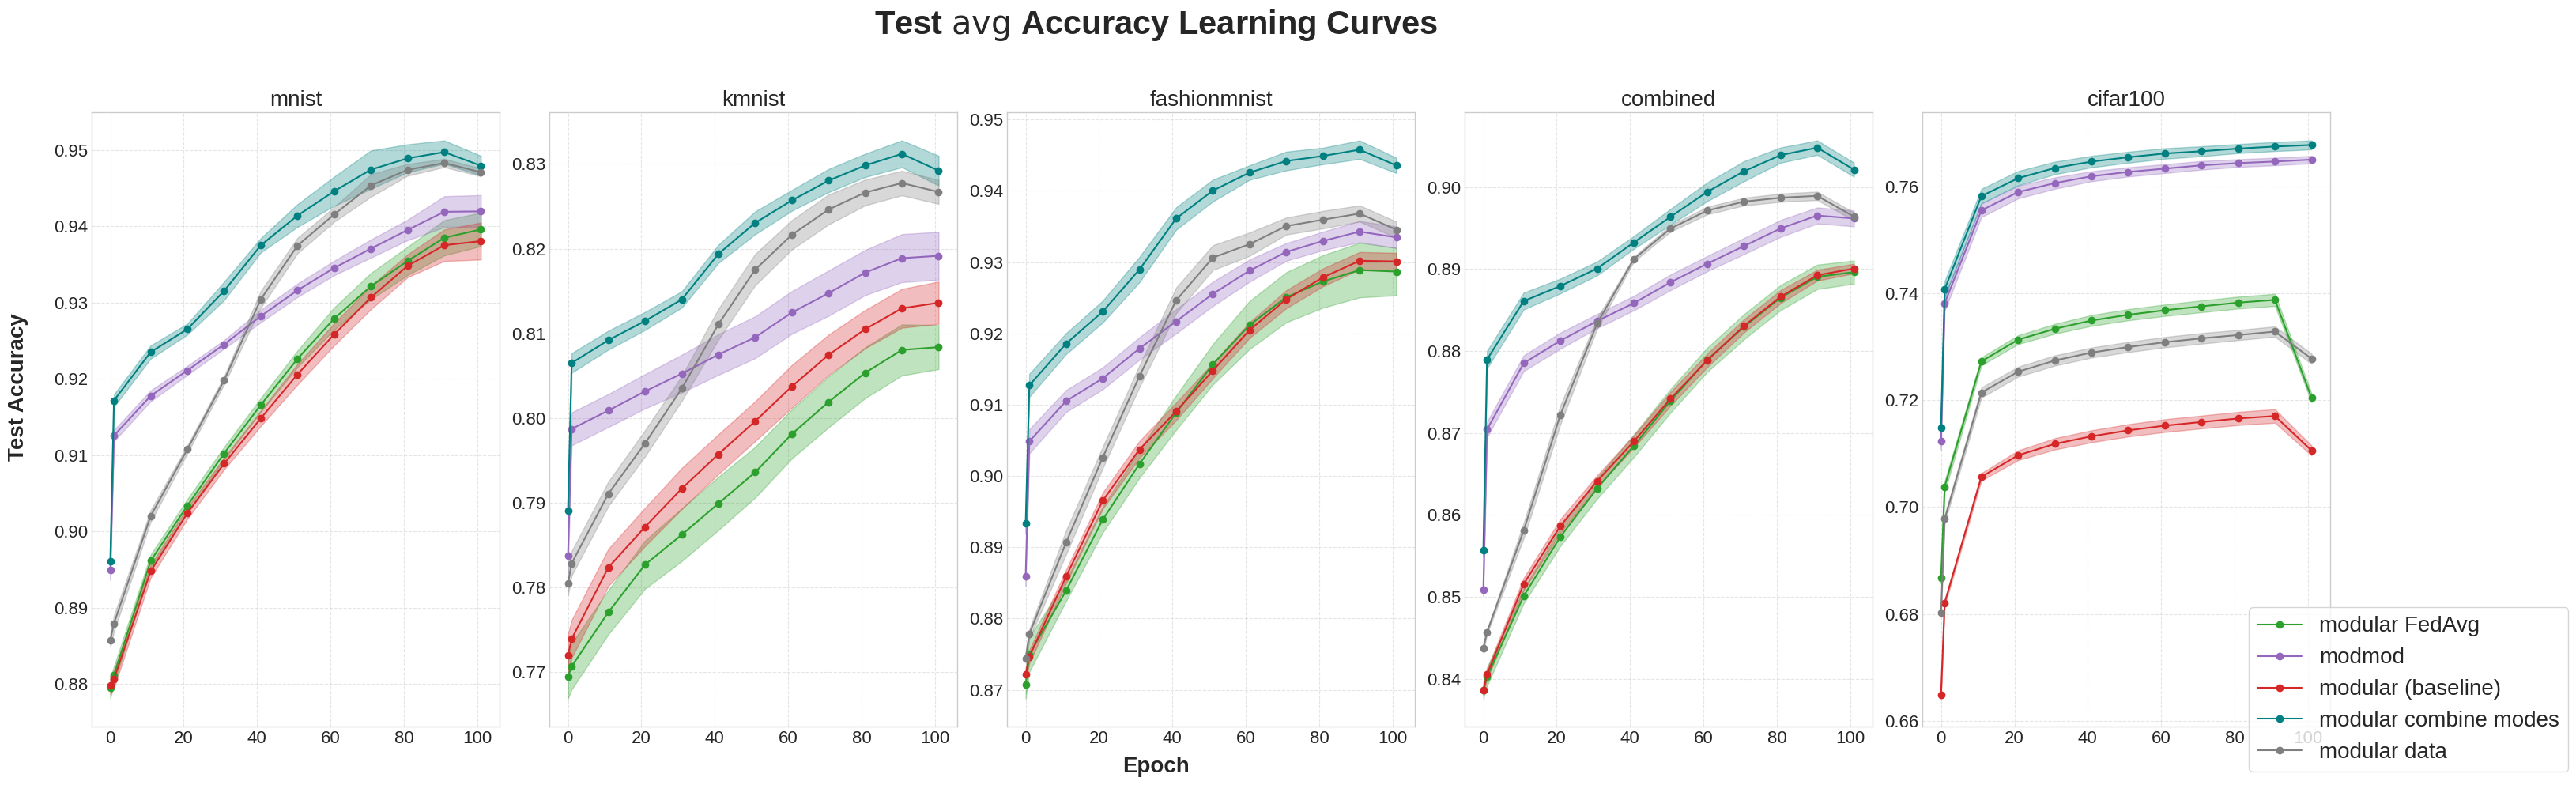

In [244]:
plot_learning_curve_dataset(dataset_agg_dfs, remap_name=remap_name, colormap=colormap,
                            mode=mode, 
                            save_fig_path=f'Figures/{what_to_plot}_lc.pdf',
                            error_type='sem',
                            metric=metric)

In [245]:
custom_algo_order = ['modmod',
 'random (p=0.25)',
 'random (p=0.5)',
 'random (p=0.7)',
 'random (p=0.9)',
 'modular (baseline)',
 'server',
 'ring',
 'tree']



# custom_algo_order = ['monolithic FedAvg',
#  'random (p=0.25)',
#  'random (p=0.5)',
#  'random (p=0.7)',
#  'random (p=0.9)',
#  'monolithic (baseline)',
#  'server',
#  'ring',
#  'tree']


# custom_algo_order = ['modular FedAvg',
#  'random (p=0.25)',
#  'random (p=0.5)',
#  'random (p=0.7)',
#  'random (p=0.9)',
#  'modular (baseline)',
#  'server',
#  'ring',
#  'tree']

In [246]:
colormap_alternative_0 = {
    'modmod': '#1f77b4',  # Blue, p=0.0
    'random (p=0.25)': '#4e90a4',  # Transition color
    'random (p=0.5)': '#7daa94',  # Transition color
    'random (p=0.7)': '#acC484',  # Transition color
    'random (p=0.9)': '#dbcE74',  # Transition color
    'modular (baseline)': '#ff7f0e',  # Orange, p=1.0
    'server': '#2ca02c',  # Green, distinct topology
    'ring': '#d62728',  # Red, distinct topology
    'tree': '#9467bd'   # Purple, distinct topology
}

# colormap_alternative_0 = {
#     'monolithic FedAvg': '#1f77b4',  # Blue, p=0.0
#     'random (p=0.25)': '#4e90a4',  # Transition color
#     'random (p=0.5)': '#7daa94',  # Transition color
#     'random (p=0.7)': '#acC484',  # Transition color
#     'random (p=0.9)': '#dbcE74',  # Transition color
#     'monolithic (baseline)': '#ff7f0e',  # Orange, p=1.0
#     'server': '#2ca02c',  # Green, distinct topology
#     'ring': '#d62728',  # Red, distinct topology
#     'tree': '#9467bd'   # Purple, distinct topology
# }


# colormap_alternative_0 = {
#     'modular FedAvg': '#1f77b4',  # Blue, p=0.0
#     'random (p=0.25)': '#4e90a4',  # Transition color
#     'random (p=0.5)': '#7daa94',  # Transition color
#     'random (p=0.7)': '#acC484',  # Transition color
#     'random (p=0.9)': '#dbcE74',  # Transition color
#     'modular (baseline)': '#ff7f0e',  # Orange, p=1.0
#     'server': '#2ca02c',  # Green, distinct topology
#     'ring': '#d62728',  # Red, distinct topology
#     'tree': '#9467bd'   # Purple, distinct topology
# }



In [247]:
custom_algo_order = [
# 'modmod+data+fed',
# 'modmod+data',
# 'modmod+fed',
'data+fed',
# 'modmod',
# 'data',
# "modular data",
"monolithic data",
# 'fed',
# 'modular FedAvg',
# 'modular (baseline)',

'monolithic FedAvg',
'monolithic (baseline)',
]

dataset mnist
modular_no_sparse_basis_True: Average AUC = 92.68, STD = 0.75, STDERR = 0.26
modmod_no_sparse_True_recv_mod_add_data_backward_True_make_new_opt_False: Average AUC = 94.06, STD = 0.81, STDERR = 0.29
recv_data+grad_sharing_no_sparse_True_recv_mod_add_data_backward_True_make_new_opt_False: Average AUC = 93.97, STD = 0.78, STDERR = 0.28
grad_sharing_no_sparse_True_recv_mod_add_data_backward_True_make_new_opt_False: Average AUC = 92.89, STD = 0.91, STDERR = 0.32
recv_data+modmod+grad_sharing_no_sparse_True_recv_mod_add_data_backward_True_make_new_opt_False: Average AUC = 94.75, STD = 0.73, STDERR = 0.26
modmod+recv_data_no_sparse_True_recv_mod_add_data_backward_True_make_new_opt_False: Average AUC = 94.69, STD = 0.68, STDERR = 0.24
recv_data_no_sparse_True_recv_mod_add_data_backward_True_make_new_opt_False: Average AUC = 93.99, STD = 0.77, STDERR = 0.27
modmod+grad_sharing_no_sparse_True_recv_mod_add_data_backward_True_make_new_opt_False: Average AUC = 93.93, STD = 0.88, STDER

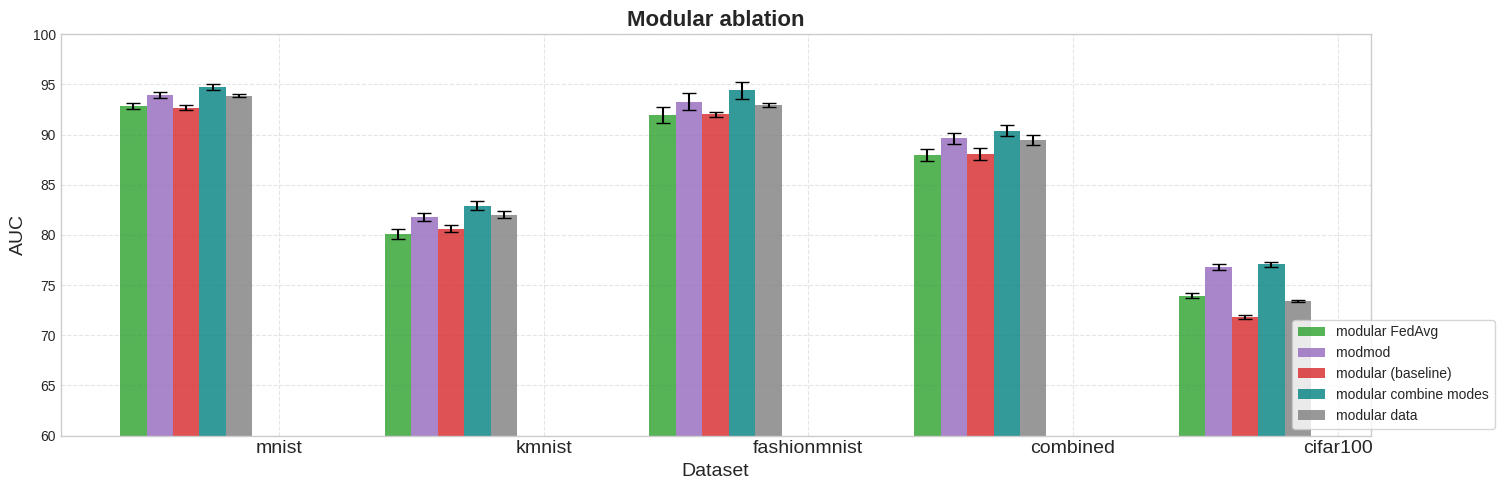

In [248]:
# plot_auc_combined(dataset_seed_aucs, remap_name=remap_name, colormap=colormap_alternative_0, mode=mode, save_fig_path=f'Figures/{what_to_plot}_auc.pdf',
#                   bar_width=0.05,
#                   custom_algo_order=custom_algo_order,
#                   plot_prefix_name="Different FedAvg monolithic network topologies ",
#                   error_type="sem")

custom_algo_order = [
  'modmod',
  'transfer modules + structure',
  'transfer modules',
  'modular (baseline)',
]
plot_auc_combined(dataset_seed_aucs, remap_name=remap_name, colormap=colormap, mode=mode, save_fig_path=f'Figures/{what_to_plot}_auc.pdf',
                # custom_algo_order=custom_algo_order,
                  # bar_width=0.05,
                  plot_prefix_name="Modular ablation",
                  error_type="sem",
                  min_y=60,
                  figsize=(15, 5)
)
                  # min_y=60, max_y=100, figsize=(20, 5))

Monolithic



Cifar100 ~ (good for more_fl_fix_root_agent_fix_fedprox_excluded_set_results)

- FedProx (mu=1.0)	68.45766 +/- 0.27
- monolithic (baseline)	65.59769 +/- 0.84
- monolithic FedAvg	69.10859 +/- 0.32


combined: also looks good for more_fl_fix_root_agent_fix_fedprox_results


Modular
 more_fl_fix_root_agent_results

cifar100
FedCurv (mu=1.0)	70.12607 +/- 0.19 ~ same as modular (baseline): 

combined
FedCurv (mu=1.0)	70.12607 +/- 0.19	75.11895 +/- 0.49
FedProx (mu=0.001)	69.84087 +/- 0.23	74.95182 +/- 0.48

more_fl_fix_root_agent_fix_fedprox_excluded_set_results

